# Rock-Paper-Scissors

In [1]:
%matplotlib inline

## 2.4 Worked Example: Rock-Paper-Scissors
The code below is a faithful Python re-implementation of the original Java version `RPSTrainer.java` as developed in section 2.4 of Neller's & Lanctot's lecture notes. This code can be run directly from `RPSTrainer0.py` in this repository.

Note that the Python version has less code than the Java version, thanks to builtin ranges and `NumPy`'s vectorized operations such as `+=`, `/=` and `/` and builtin functions such as `sum`, `clip`, `repeat` and `zeros`. We have also leveraged `NumPy`'s `random.choice` to sample actions from a strategy.

In [2]:
# %load RPSTrainer0.py
#          Copyright Rein Halbersma 2018.
# Distributed under the Boost Software License, Version 1.0.
#    (See accompanying file LICENSE_1_0.txt or copy at
#          http://www.boost.org/LICENSE_1_0.txt)

import numpy as np

class RPSTrainer:
    def __init__(self):
        self.NUM_ACTIONS = 3
        self.regretSum = np.zeros(self.NUM_ACTIONS)
        self.strategySum = np.zeros(self.NUM_ACTIONS)
        self.oppStrategy = [.4, .3, .3]
    
    def getStrategy(self):
        strategy = self.regretSum.clip(min=0)
        normalizingSum = np.sum(strategy)
        if normalizingSum > 0:
            strategy /= normalizingSum
        else:
            strategy = np.repeat(1 / self.NUM_ACTIONS, self.NUM_ACTIONS)
        self.strategySum += strategy
        return strategy
    
    def getAction(self, strategy):
        return np.random.choice(len(strategy), p=strategy)
    
    def train(self, iterations):
        actionUtility = np.zeros(self.NUM_ACTIONS)
        
        for i in range(iterations):
            strategy = self.getStrategy()
            myAction = self.getAction(strategy)
            otherAction = self.getAction(self.oppStrategy)
            
            actionUtility[otherAction] = 0
            actionUtility[0 if otherAction == self.NUM_ACTIONS - 1 else otherAction + 1] = 1
            actionUtility[self.NUM_ACTIONS - 1 if otherAction == 0 else otherAction - 1] = -1
            
            for a in range(self.NUM_ACTIONS):
                self.regretSum[a] += actionUtility[a] - actionUtility[myAction]
    
    def getAverageStrategy(self):
        normalizingSum = np.sum(self.strategySum)
        if normalizingSum > 0:
            avgStrategy = self.strategySum / normalizingSum
        else:
            avgStrategy = np.repeat(1 / self.NUM_ACTIONS, self.NUM_ACTIONS)
        return avgStrategy
        
def main():
    trainer = RPSTrainer()
    trainer.train(1000000)
    print(trainer.getAverageStrategy())
    
if __name__ == "__main__":
    main()


[2.32310306e-04 9.99767356e-01 3.33333333e-07]


Running this code shows that after training for 1 million iterations against an opponent playing Rock 40% of the time, the average strategy has converged to the best response of playing Paper 100% of the time.

### Measuring the rate of convergence

In order to know how fast the algorithm converges, we adapt the code to save the intermediate average strategies and its exploitability. We then make a log-log plots of these quantities versus the iteration number. This code can be run directly from `RPSTrainer1.py` in this repository.

Note that we refactored the code a bit compared to version 0: moving the update of `strategySum` from `getStrategy()` to `train()`, factoring the normalization of a strategy vector into a separate `normalize()` function, adding `bestResponse()` and `exploitability()` functions and moving the `actionUtility` into a matrix. Finally, the `train()` function now returns a `Pandas` data frame that can be analyzed after training has completed. In the spirit of Reinforcement Learning, the trained `averageStrategy()` is called `target_policy`. 

Target policy: [9.58130445e-05 9.99873837e-01 3.03495355e-05]


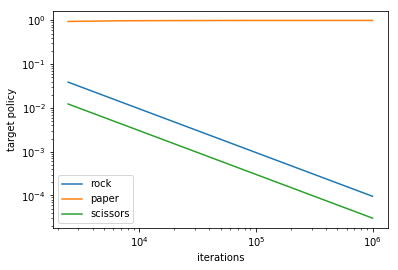

Exploitability: 1.5651211550057406e-05


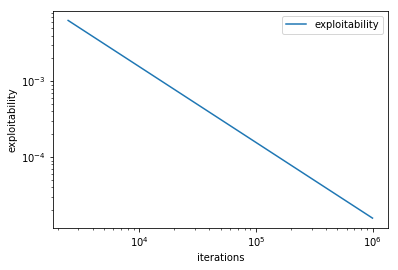

Intercept             2.750352
np.log(iterations)   -0.999985
dtype: float64


In [3]:
# %load RPSTrainer1.py
#          Copyright Rein Halbersma 2018.
# Distributed under the Boost Software License, Version 1.0.
#    (See accompanying file LICENSE_1_0.txt or copy at
#          http://www.boost.org/LICENSE_1_0.txt)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm

class RPSTrainer:
    def __init__(self):
        self.NUM_ACTIONS = 3
        self.actionUtility = np.array([
            [0, -1, 1],
            [1, 0, -1],
            [-1, 1, 0]
        ])        
        self.regretSum = np.zeros(self.NUM_ACTIONS)
        self.strategySum = np.zeros(self.NUM_ACTIONS)
        self.oppStrategy = [.4, .3, .3]
    
    def normalize(self, strategy):
        normalizingSum = np.sum(strategy)
        if normalizingSum > 0:
            strategy /= normalizingSum
        else:
            strategy = np.repeat(1 / self.NUM_ACTIONS, self.NUM_ACTIONS)
        return strategy       
    
    def getStrategy(self):
        return self.normalize(self.regretSum.clip(min=0))
    
    def getAverageStrategy(self):
        return self.normalize(np.copy(self.strategySum))
        
    def getAction(self, strategy):
        return np.random.choice(len(strategy), p=strategy)
    
    def bestResponse(self, utility): 
        return np.eye(self.NUM_ACTIONS)[np.argmax(utility)]
        
    def exploitability(self, strategy):
        utility = np.dot(self.actionUtility, self.oppStrategy)
        return np.dot(self.bestResponse(utility) - strategy, utility)
    
    def train(self, iterations, df=None, sample=.001):        
        for i in range(iterations):
            strategy = self.getStrategy()
            self.strategySum += strategy
            myAction = self.getAction(strategy)
            otherAction = self.getAction(self.oppStrategy)
            
            self.regretSum += self.actionUtility[:, otherAction] - self.actionUtility[myAction, otherAction]
                
            if df is None or np.random.random() > sample:
                continue
            target_policy = self.getAverageStrategy()
            df = df.append(
                pd.DataFrame(
                    np.append(
                        np.array([i, self.exploitability(target_policy)]),
                        target_policy                        
                    ).reshape(-1, 2 + self.NUM_ACTIONS), 
                    columns=list(df)
                ), 
                ignore_index=True
            )
        
        return df
    
def main():
    columns = ['iterations', 'exploitability', 'rock', 'paper', 'scissors']
    df = pd.DataFrame(columns=columns)        
    
    trainer = RPSTrainer()
    df = trainer.train(1000000, df)
    target_policy = trainer.getAverageStrategy()
    
    print('Target policy: %s' % (target_policy))
    for c in columns[2:]:
        plt.loglog(df[columns[0]], df[c], label=c)
    plt.xlabel(columns[0])
    plt.ylabel('target policy')
    plt.legend()
    plt.show()
    
    print('Exploitability: %s' % (trainer.exploitability(target_policy)))
    plt.loglog(df[columns[0]], df[columns[1]])
    plt.xlabel(columns[0])
    plt.ylabel(columns[1])
    plt.legend()
    plt.show()
    
    model = sm.ols(formula="np.log(exploitability) ~ np.log(iterations)", data=df).fit()
    print(model.params)
    
if __name__ == "__main__":
    main()


We see that the rate of convergence is inversely linear: to get exploitability less than $\varepsilon$, we need at $\mathcal{O}(\varepsilon^{-1})$ iterations. A million iterations are needed to reduce exploitability to one part per million.